## On semantic segmentation: training of a simplified model



#### Import packages

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

if not os.path.exists('./logger/'):
    os.mkdir('./logger/')
if not os.path.exists('./models/'):
    os.mkdir('./models/')

import torch
import torch.nn as nn
import torch.utils.data as data
from torch import optim
from torchvision import transforms
import torchvision.transforms.functional as TF

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import time

print('PyTorch version:', torch.__version__)
torch.cuda.is_available()
torch.cuda.get_device_name(0)

PyTorch version: 1.13.1+cu117


'NVIDIA GeForce RTX 2060'

#### Set up Hyperparameters + Enable GPU acceleration

In [2]:
class Configuration:
  def __init__(self):
    self.experiment_name = "Training the Super Mario Segmentation Model"
    
    # Paramters for the first part
    self.pre_load = "True"  # Load dataset in memory
    self.pre_trained = "True"
    self.num_classes = 6
    self.ignore_label = 255
    self.training_data_proportion = 0.8  # Proportion of images of the dataset to be used for training

    self.lr = 0.001  # 0.001 if pretrained weights from pytorch. 0.1 if scratch
    self.epoch = 20  # Play with this if training takes too long
    self.M = [37,42]  # If training from scratch, reduce learning rate at some point

    self.batch_size = 4  # Training batch size
    self.test_batch_size = 4  # Test batch size
    self.model_file_name = "MarioSegmentationModel.pth"  # Name of the output model's weights
    
    # Where you have generated the dataset
    self.dataset_root = "C:/Users/Choutianxius/projects/mario-semantic/dataset_generator/dataset"
    self.download = False
    
    self.seed = 271828

## Create arguments object
args = Configuration()

device = 'cuda'

# Set random seed for reproducibility
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)

### Dataset class

In [3]:
class MarioDataset(data.Dataset):
    def __init__(self, args, mode, transform_input=transforms.ToTensor(), transform_mask=transforms.ToTensor()):
        self.args = args
        self.folder = args.dataset_root

        #If you change how you create the dataset you may need to modify this:
        self.images_in_dataset = 10000
        training_images_no = int(self.images_in_dataset*0.8)
        self.imgs = np.arange(training_images_no) if mode == 'train' else np.arange(training_images_no,self.images_in_dataset)

        if len(self.imgs) == 0:
            raise RuntimeError('Found 0 images, please check the data set or proportions')

        self.mode = mode
        self.transform_input = transform_input
        self.transform_mask = transform_mask

    # Default trasnformations on train data
    def transform(self, image, mask):

        i, j, h, w = transforms.RandomCrop.get_params(image, (224,224))
        
        image = TF.crop(image,i,j,h,w)
        mask  = TF.crop(mask,i,j,h,w)

        if random.random() > 0.5:
            image = TF.hflip(image)
            mask  = TF.hflip(mask)

        return image, mask

    # Default trasnformations on test data
    def test_transform(self, image, mask):
        #224x224 center crop: 
        image = TF.center_crop(image,[224,224])
        mask  = TF.center_crop(mask,[224,224])

        return image, mask
    
    def __getitem__(self, index):

        if self.mode == 'test':
            img = Image.open(+self.folder+"/PNG/"+str(index)+".png").convert('RGB')
            if self.transform is not None:
                img = self.transform(img)
            return str(index), img

            #Load RGB image
        img = Image.open(self.folder+"/PNG/"+str(index)+".png").convert('RGB')

        if self.mode == 'train':

            #Load class mask
            mask = Image.open(self.folder+"/Labels/"+str(index)+".png")
        else:
            mask = Image.open(self.folder+"/Labels/"+str(index)+".png")

            ##Transform using default transformations
        if self.mode=="train":
              img, mask = self.transform(img,mask)
        else:
              img, mask = self.test_transform(img,mask)

        if self.transform_input is not None:
            img = self.transform_input(img)
        if self.transform_mask is not None:
            mask = 255*self.transform_mask(mask)

        return img, mask.long()

    def __len__(self):
        return len(self.imgs)

### Training Epoch
Per-pixel cross-entropy loss is to be computed. 

In [4]:
def train_epoch(args, model, device, train_loader, optimizer, epoch):
    # switch to train mode
    model.train()

    train_loss = []
    counter = 1

    criterion = nn.CrossEntropyLoss(ignore_index=255)

    for batch_idx, (images, mask) in enumerate(train_loader):

        images, mask = images.to(device), mask.to(device)

        outputs = model(images)['out']
 
        #Aggregated per-pixel loss
        loss = criterion(outputs, mask.squeeze(1))
        train_loss.append(loss.item())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if counter % 15 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Learning rate: {:.6f}'.format(
                epoch, int(counter * len(images)), len(train_loader.dataset),
                100. * counter / len(train_loader), loss.item(),
                optimizer.param_groups[0]['lr']))
        counter = counter + 1
    
    return sum(train_loss) / len(train_loss) # per batch averaged loss for the current epoch.

### Validation epoch
Per-pixel cross-entropy loss is to be computed. 
To this iam, we rely on a function to extract the histogram of the predicted classes: _fast_hist


In [5]:
def _fast_hist(label_pred, label_true, num_classes):
    mask = (label_true >= 0) & (label_true < num_classes)
    hist = np.bincount(
        num_classes * label_true[mask].astype(int) +
        label_pred[mask], minlength=num_classes ** 2).reshape(num_classes, num_classes)
    return hist

def testing(args, model, device, test_loader):

    model.eval()

    loss_per_batch = []

    criterion = nn.CrossEntropyLoss(ignore_index=255)

    gts_all, predictions_all = [], []
    with torch.no_grad():
        for batch_idx, (images, mask) in enumerate(test_loader):

            images, mask = images.to(device), mask.to(device)

            outputs = model(images)['out']

            loss = criterion(outputs,mask.squeeze(1))
            loss_per_batch.append(loss.item())

            # Adapt output size for histogram calculation.
            preds = outputs.data.max(1)[1].squeeze(1).squeeze(0).cpu().numpy()
            gts_all.append(mask.data.squeeze(0).cpu().numpy())
            predictions_all.append(preds)

    loss_per_epoch = [np.average(loss_per_batch)]

    hist = np.zeros((args.num_classes, args.num_classes))
    for lp, lt in zip(predictions_all, gts_all):
        hist += _fast_hist(lp.flatten(), lt.flatten(), args.num_classes)

    iou = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))

    plt.figure()
    plt.bar(np.arange(args.num_classes), iou)
    plt.title('Class Accuracy in the validation set ')
    plt.show()

    mean_iou = np.nanmean(iou)

    print('\nTest set ({:.0f}): Average loss: {:.4f}, mIoU: {:.4f}\n'.format(
        len(test_loader.dataset), loss_per_epoch[-1], mean_iou))

    return (loss_per_epoch, mean_iou)

### Dataloaders definition


In [6]:
workers = 0 # Anything over 0 will crash on windows. On linux it works fine.

trainset = MarioDataset(args, 'train')
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=workers, pin_memory=True)

testset = MarioDataset(args, 'val')
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=False, num_workers=workers, pin_memory=True)


### Define model and download pretrained weights.

In [7]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

from torchvision import models

model = models.segmentation.deeplabv3_resnet50(
        pretrained=True, progress=True)
model.classifier = DeepLabHead(2048, 6)

model = model.to(device)

C:\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Define the optimizer and the scheduler

In [8]:
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=args.M, gamma=0.1)

### Training loop for semantic segmentation

In [ ]:
loss_train_epoch = []
loss_test_epoch = []
acc_train_per_epoch = []
acc_test_per_epoch = []
new_labels = []

try:
    cont = 0

    for epoch in range(1, args.epoch + 1):
        st = time.time()

        print("DeepLabV3_Resnet50 training, epoch " + str(epoch))
        loss_per_epoch = train_epoch(args,model,device,train_loader,optimizer,scheduler)

        loss_train_epoch += [loss_per_epoch]

        scheduler.step()

        loss_per_epoch_test, acc_val_per_epoch_i = testing(args,model,device,test_loader)

        loss_test_epoch += loss_per_epoch_test
        acc_test_per_epoch += [acc_val_per_epoch_i]

        if epoch == 1:
            best_acc_val = acc_val_per_epoch_i

        else:
            if acc_val_per_epoch_i > best_acc_val:
                best_acc_val = acc_val_per_epoch_i

        if epoch==args.epoch:
            torch.save(model.state_dict(), "./models/"+args.model_file_name)

        cont += 1

except:
    torch.save(model.state_dict(), "./models/"+args.model_file_name)

In [12]:
np.save('./logger/loss_train_epoch', loss_train_epoch)
np.save('./logger/loss_test_epoch', loss_test_epoch)
np.save('./logger/acc_train_per_epoch', acc_train_per_epoch)
np.save('./logger/acc_test_per_epoch', acc_test_per_epoch)
np.save('./logger/new_labels', new_labels)

### Accuracy and loss curves for semantic segmentation

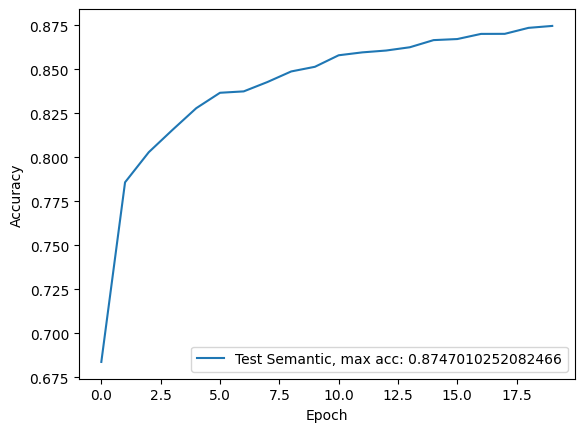

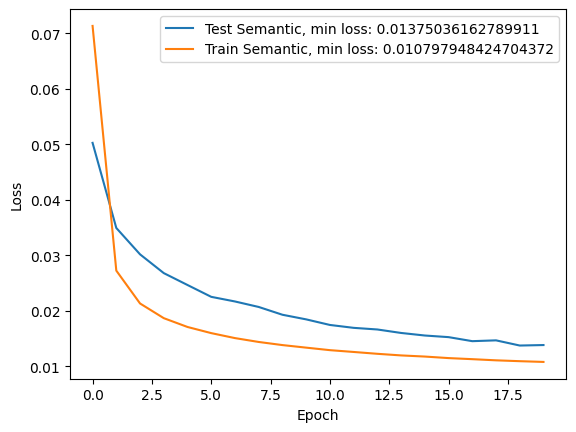

In [10]:
##Accuracy
acc_test  = np.asarray(acc_test_per_epoch)

#Loss per epoch
loss_test  = np.asarray(loss_test_epoch)
loss_train = np.asarray(loss_train_epoch)

numEpochs = len(acc_test)
epochs = range(numEpochs)

plt.figure(1)
plt.plot(epochs, acc_test, label='Test Semantic, max acc: ' + str(np.max(acc_test)))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(2)
plt.plot(epochs, loss_test, label='Test Semantic, min loss: ' + str(np.min(loss_test)))
plt.plot(epochs, loss_train, label='Train Semantic, min loss: ' + str(np.min(loss_train)))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

Now you can use the saved weights to load the model and generate semantic segmentations for Super Mario Game scenes.

### Load and test model

This part is independent from the above code. You can revisit this part, load and test the model any time after training is completed.

In [18]:
model = models.segmentation.deeplabv3_resnet50(
        pretrained=True, progress=True)
# Added a Sigmoid activation after the last convolution layer
model.classifier = DeepLabHead(2048, 6)

# models/MarioSegmentationModel.pth
model.load_state_dict(torch.load("models/MarioSegmentationModel.pth"))
model.cuda()

C:\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [19]:
# Define the helper function
def decode_segmap(image, nc=21):
    ## Color palette for visualization of the 21 classes
    label_colors = np.array([(0, 0, 0),  # 0=background
    # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
    (0, 0,255), (127, 127, 0), (0, 255, 0), (255, 0, 0), (255, 255, 0),
    # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
    (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
    # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
    (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
    # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
    (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
  
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def segment(net, path, show_orig=True,transform=transforms.ToTensor(), dev='cuda'):
    img = Image.open(path)
    if show_orig: plt.imshow(img); plt.axis('off'); plt.show()

    input_image = transform(img).unsqueeze(0).to(dev)
    out = net(input_image)['out'][0]

    segm = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    segm_rgb = decode_segmap(segm)
    plt.imshow(segm_rgb)
    plt.axis('off')
    #plt.savefig('1_1.png', format='png',dpi=300,bbox_inches = "tight")
    plt.show()

Test the model on a frame from real game:

./manually_labeled_frames/PNG/4.png


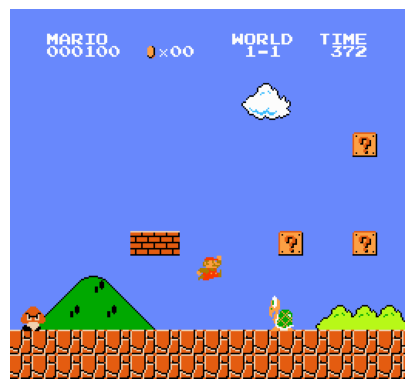

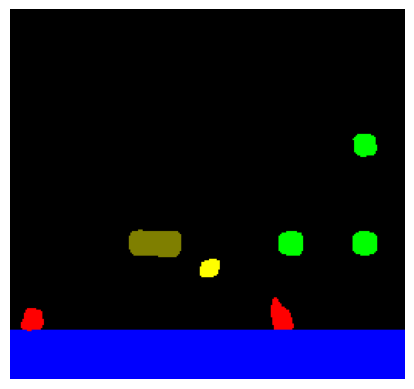

In [20]:
model.eval() #Or batch normalization gives error

frame ="./manually_labeled_frames/PNG/4.png"
print(frame)
segment(model,frame)
